In [76]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax.numpy as jnp
import pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
from process_data import process_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [81]:
# Returns the columnn names and the data
cols, data = process_data("bld1.csv")
# find indices at which the column names contain 'Zone Air Temperature'
# we want to make these what we're predicting.
# the rest is just inputs to our model
idx_temperature = np.array(['Zone Air Temperature' in col for col in cols])
X = data.iloc[:, np.array([0, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14])]
X.iloc[:, 6] = X.iloc[:,6] - X.iloc[:,7]
y = ((X.iloc[:, -3:]).to_numpy())[1:]
X = ((X.drop(columns = 'LIVING ZONE:Zone Air System Sensible Cooling Rate [W](TimeStep)')).to_numpy())[:-1]
y_diff = np.load('./models/linear_model_fitting/Pinn_target.npy').T
y_linear = y - y_diff
X = np.concatenate((X, y_linear), axis = 1)

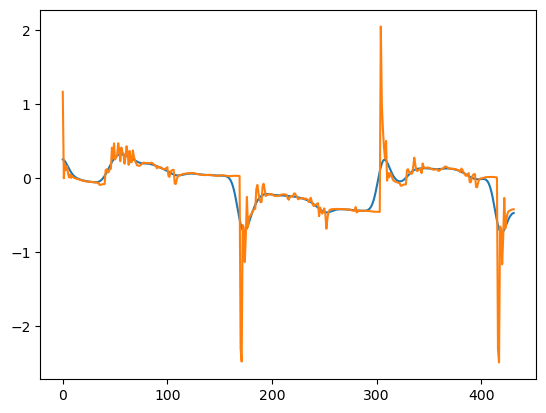

In [110]:
import scipy
smooth = scipy.ndimage.gaussian_filter(y_diff[:432, 0], 5)
plt.plot(smooth)
plt.plot(y_diff[:432, 0])

In [83]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 20)

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [84]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

In [85]:
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as pl
import itertools
import jax
import optax
import jaxopt
import pickle
import h5py
import warnings
import wandb
import process_data

warnings.filterwarnings("ignore")
from jax import random, jit, grad, jacfwd, vmap
from optax_adan import adan
from jax.nn import sigmoid, gelu, relu, softmax, softplus
from functools import partial
from tqdm import trange
from torch.utils import data
from typing import Sequence, Callable, Any, Tuple
from absl import logging

logging.set_verbosity(logging.INFO)

# from tueplots import bundles
from jax.nn.initializers import glorot_normal, normal, zeros

In [86]:
class MLP(nn.Module):
    features: Sequence[int]
    activation: Callable

    def setup(self):
        # Regular Dense layer:
        self.layers = [nn.Dense(feat, kernel_init = jax.nn.initializers.glorot_normal()) for feat in self.features]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        # Final Layer has no activation function applied:
        return self.layers[-1](x)

In [87]:
class DataGenerator(data.Dataset):
    def __init__(self, key, X, y, batch_size):
        self.key = key
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __getitem__(self, index):
        "Generate one batch of data"
        self.key, subkey = random.split(self.key)
        batch = self.__data_generation(subkey)
        return batch

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        idx = random.choice(key, self.X.shape[0], shape=(self.batch_size,))
        batch = (self.X[idx], self.y[idx])
        return batch

In [88]:
class Regression:
    def __init__(
        self,
        key,
        layers,
    ):
        # Initialize parameters:
        model1 = MLP(layers, jnp.sin)
        model2 = MLP(layers, jnp.sin)
        model3 = MLP(layers, jnp.sin)
        
        self.init1, self.apply1 = model1.init, model1.apply
        self.init2, self.apply2 = model2.init, model2.apply
        self.init3, self.apply3 = model3.init, model3.apply
        
        keys = random.split(key, 6)
        params1 = self.init1(keys[0], random.normal(keys[1], (13,)))
        params2 = self.init2(keys[2], random.normal(keys[3], (13,)))
        params3 = self.init3(keys[4], random.normal(keys[5], (13,)))
        
        self.params = (params1, params2, params3)
        self.avg_params = self.params
        learning_schedule = optax.cosine_decay_schedule(1e-3, 200000, 1e-5)
        self.optimizer = optax.adamw(1e-3, weight_decay = 1e-3)
        self.opt_state = self.optimizer.init(self.params)
        self.loss_log = []        

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        X, y = batch
        y_pred = self.predict(params, X)
        loss = jnp.mean((y_pred - y)**2)
        return loss
    
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grad = jax.grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    @partial(jit, static_argnums=(0,))
    def ema_update(self, params, avg_params):
        return optax.incremental_update(params, avg_params, step_size=0.001)
    
    def predict(self, params, X):
        y1 = self.apply1(params[0], X)
        y2 = self.apply2(params[1], X)
        y3 = self.apply3(params[2], X)
        return jnp.concatenate([y1, y2, y3], axis=1)

    # Optimize parameters in a loop
    def train(self, dataloader, nIter=10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(dataloader)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            self.avg_params = self.ema_update(self.params, self.avg_params)
            # Logger
            if it % 1000 == 0:
                params = self.avg_params
                loss = self.loss(params, batch)
                pbar.set_postfix({"loss": loss})

In [89]:
loader = iter(DataGenerator(random.PRNGKey(0), X_train, y_train, 1024))
model = Regression(random.PRNGKey(42), [256, 256, 1])

In [90]:
model.train(loader, nIter=500000)

100%|██████████| 500000/500000 [06:57<00:00, 1198.76it/s, loss=0.0005793443] 


In [94]:
norms = []
for i in trange(121):
    X_new = scaler_x.transform(X[432 * i:432 * (i + 1)])
    y_pred = scaler_y.inverse_transform(np.array(model.predict(model.avg_params, X_new)))
    norms.append(np.linalg.norm(y_pred - y[432 * i:432 * (i + 1)], axis=0).mean())

100%|██████████| 121/121 [00:12<00:00,  9.36it/s]


In [95]:
to_save = list(map(lambda x: x.unfreeze(), model.avg_params))

In [96]:
to_save.append(scaler_x.mean_)
to_save.append(scaler_x.scale_)
to_save.append(scaler_y.mean_)
to_save.append(scaler_y.scale_)

In [97]:
to_save[0] = jax.tree_map(lambda x: np.array(x), to_save[0])
to_save[1] = jax.tree_map(lambda x: np.array(x), to_save[1])
to_save[2] = jax.tree_map(lambda x: np.array(x), to_save[2])

In [98]:
with open("jax_pinn.pkl", "wb") as f:
    pickle.dump(to_save, f)

In [51]:
to_save = pickle.load(open("model_reduced.pkl", "rb"))

In [91]:
idx = 114
X_new = scaler_x.transform(X[432 * idx:432 * (idx + 1)])
y_pred = scaler_y.inverse_transform(np.array(model.predict(model.avg_params, X_new)))

In [88]:
trans = scaler_x.transform(X)

In [20]:
cols[14]

'ATTIC ZONE:Zone Air Temperature [C](TimeStep)'

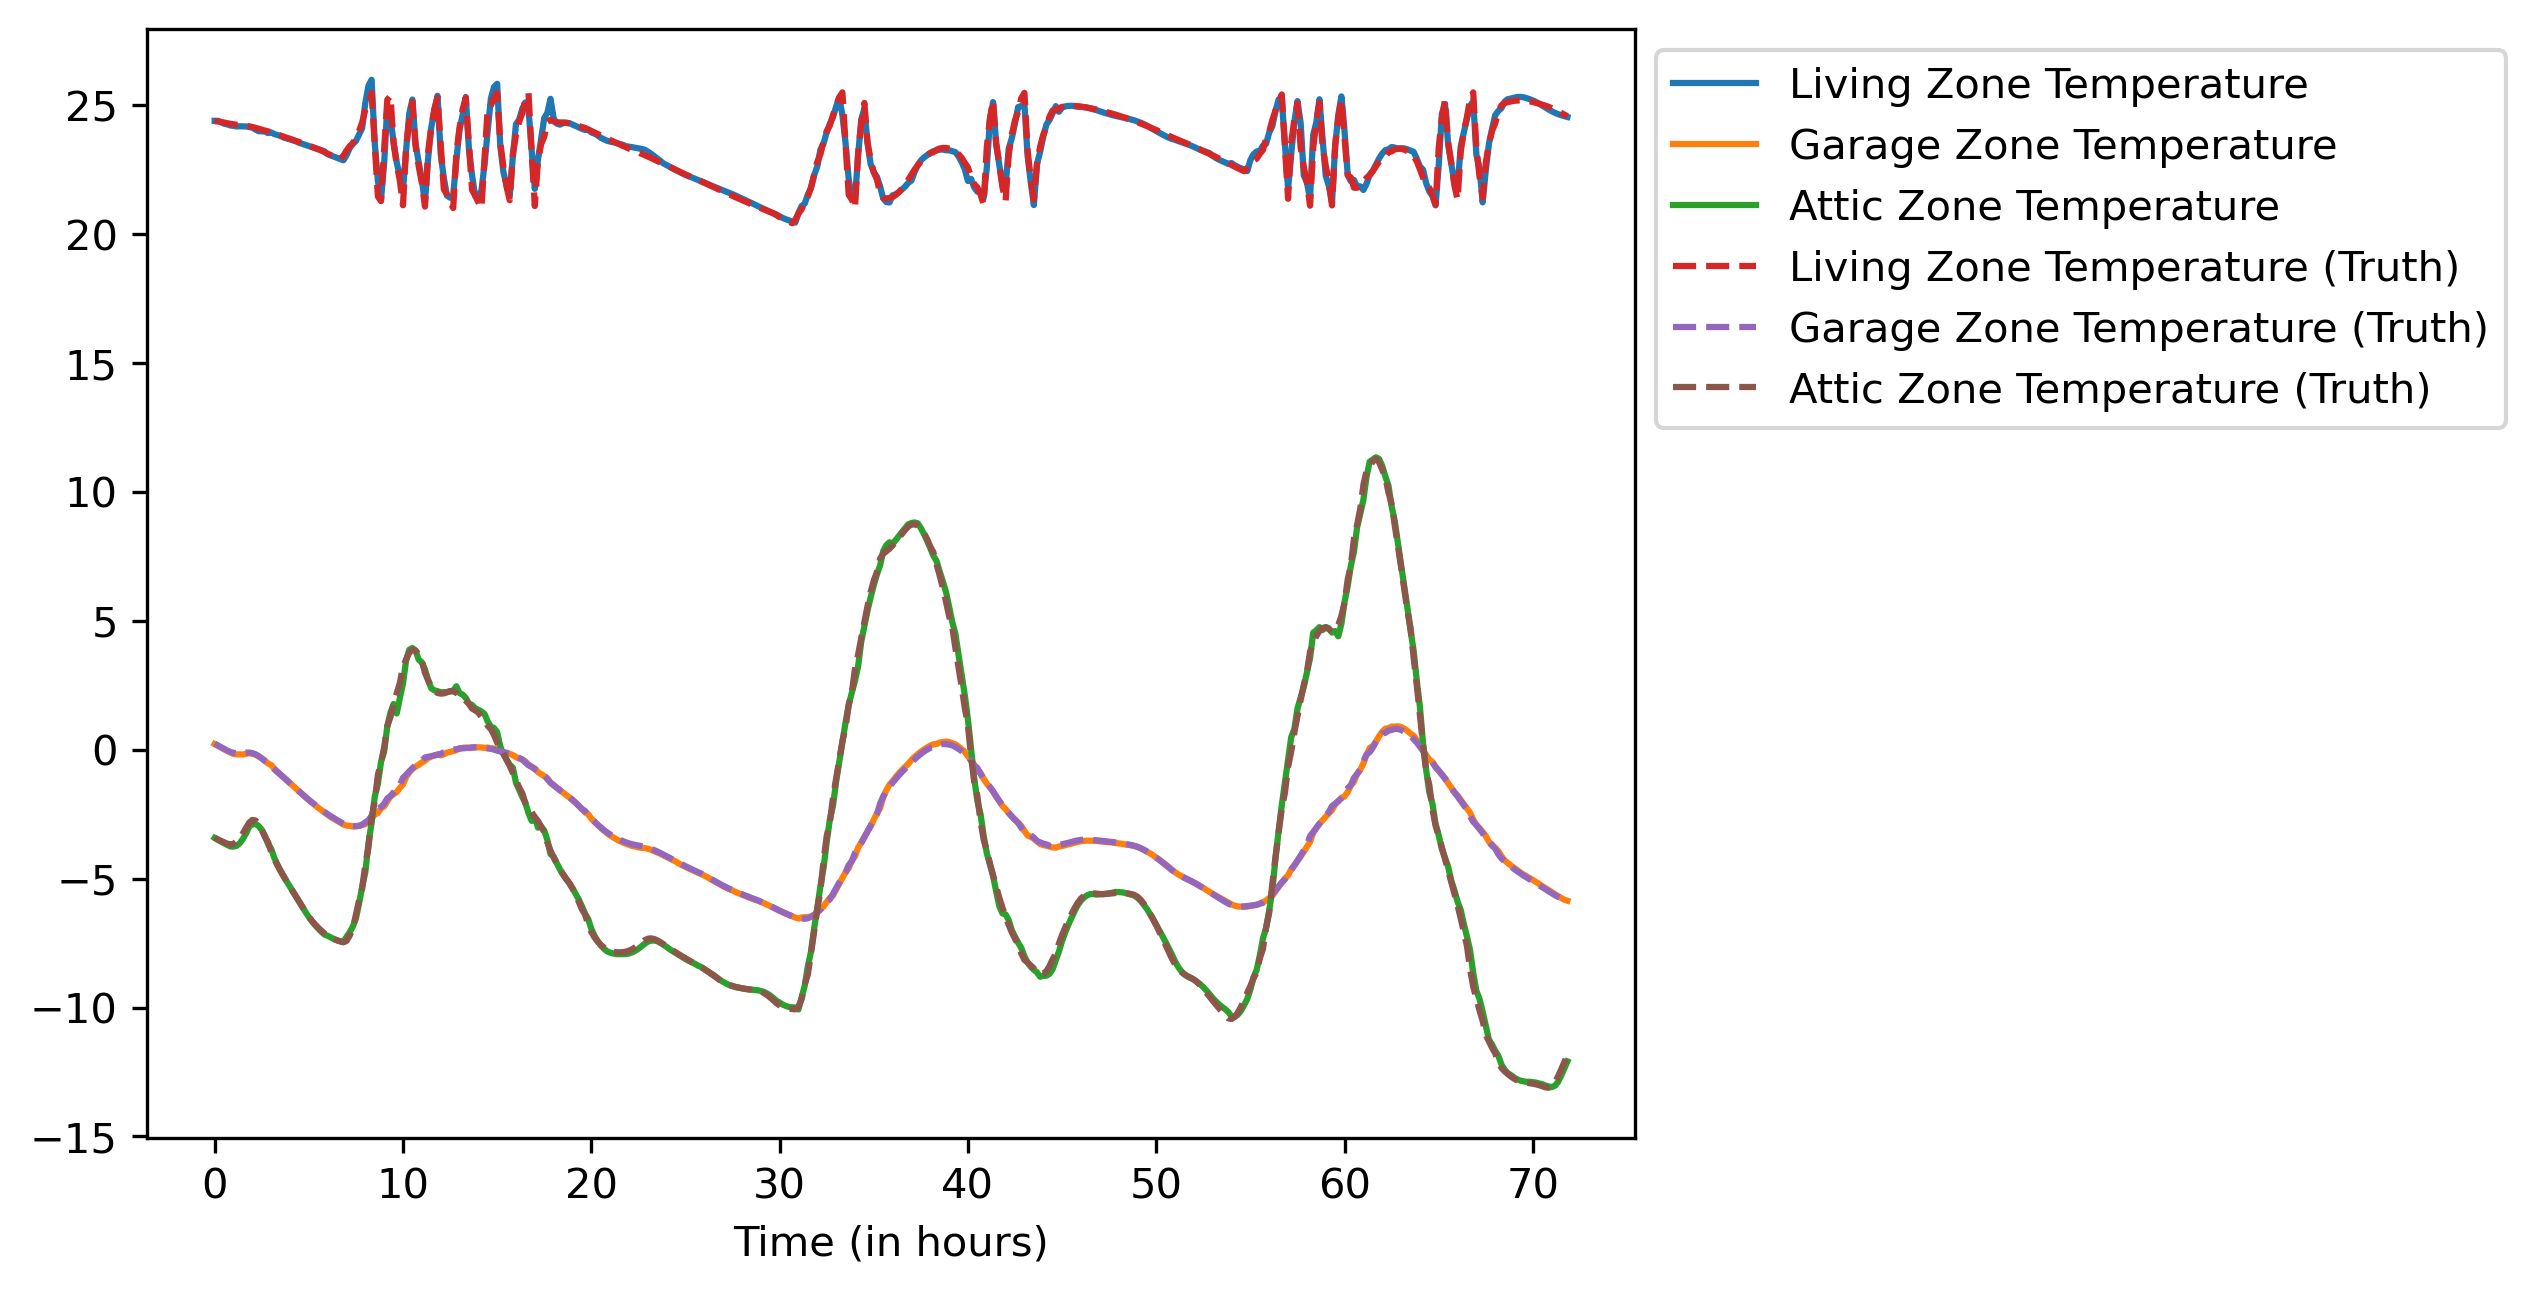

In [93]:
t = np.arange(432) / 144 * 24
pl.figure(dpi = 300)
pl.plot(t, y_pred)
pl.plot(t, y[432 * idx:432 * (idx + 1)], '--')
pl.xlabel('Time (in hours)')
pl.legend(['Living Zone Temperature', 'Garage Zone Temperature', 'Attic Zone Temperature',
           'Living Zone Temperature (Truth)', 'Garage Zone Temperature (Truth)', 'Attic Zone Temperature (Truth)'],
          bbox_to_anchor=(1, 1))

In [96]:
# W1 = model.avg_params[0][0]

scaler_y.inverse_transform(model.predict(model.avg_params, scaler_x.transform(jnp.ones([1, 44]))))

array([[22.922237, 16.64193 , 33.47328 ]], dtype=float32)

In [90]:
W1 = model.avg_params[0]['params']['layers_0']['kernel']
b1 = model.avg_params[0]['params']['layers_0']['bias']

W2 = model.avg_params[0]['params']['layers_1']['kernel']
b2 = model.avg_params[0]['params']['layers_1']['bias']

W3 = model.avg_params[0]['params']['layers_2']['kernel']
b3 = model.avg_params[0]['params']['layers_2']['bias']

def manual(X):
    return jnp.sin(jnp.sin(X @ W1 + b1) @ W2 + b2) @ W3 + b3

In [94]:
to_save[0]

{'params': {'layers_0': {'bias': DeviceArray([ 6.74583986e-02, -9.36144148e-04,  2.05812305e-01,
                 1.40750892e-02,  1.02983646e-01, -4.52906966e-01,
                 2.93234617e-01,  8.34141895e-02, -1.08319982e-04,
                 1.28890306e-01, -3.59766331e-04,  8.05243403e-02,
                 3.35270801e-04, -2.35963264e-04, -1.76044866e-01,
                 2.60953646e-04,  3.89543086e-01,  2.14583088e-05,
                -1.21151847e-04, -6.39875434e-05,  4.14365500e-01,
                 3.52628231e-01,  2.76289806e-02,  9.96824726e-03,
                -2.40570620e-01,  8.53439420e-02,  3.26120667e-02,
                 3.75369936e-01, -4.18455384e-05, -5.28229401e-02,
                -2.43087766e-06, -4.68144007e-02, -4.54732567e-01,
                 1.20439246e-01,  2.29477793e-01, -6.06554141e-03,
                -3.61928374e-01, -2.36623973e-01, -2.76631325e-01,
                -4.87198561e-01,  6.54625148e-02, -2.07746491e-01,
                -1.40094995e-01,

In [91]:
def SIREN(x, params):
    weights1, weights2, weights3, mu_x, var_x, mu_t, var_t = params

    def forward(x, weights):


        W1 = weights['params']['layers_0']['kernel']
        b1 = weights['params']['layers_0']['bias']

        W2 = weights['params']['layers_1']['kernel']
        b2 = weights['params']['layers_1']['bias']

        W3 = weights['params']['layers_2']['kernel']
        b3 = weights['params']['layers_2']['bias']


        return np.sin(np.sin(x @ W1 + b1) @ W2 + b2) @ W3 + b3


    
    return forward(x, weights1)

In [92]:
SIREN(np.ones([1, 44]), to_save)

DeviceArray([[1.386715]], dtype=float32)

In [80]:
manual(np.ones([1, 44]))

DeviceArray([[1.386715]], dtype=float32)

In [15]:
from sklearn.metrics import r2_score
acte = r2_score(y[432 * idx:432 * (idx + 1)], y_pred)
print(acte)

0.9977263606959302


(44, 256)